In [0]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np
import math
import scipy.interpolate as interp
import pandas as pd
import csv

In [0]:
from measurements.galaxy_1 import red, blue, times
#Convert to arrays
# SPO2 96-97 HR 70
red_array= np.array(red)
blue_array = np.array(blue)
time_points = np.array([(t -times[0])/(10**9) for t in times ])

# Not sure why this happenes
red_time_diff= len(times) - len(red)
blue_time_diff = len(times) - len(blue)
signal_cut = 70

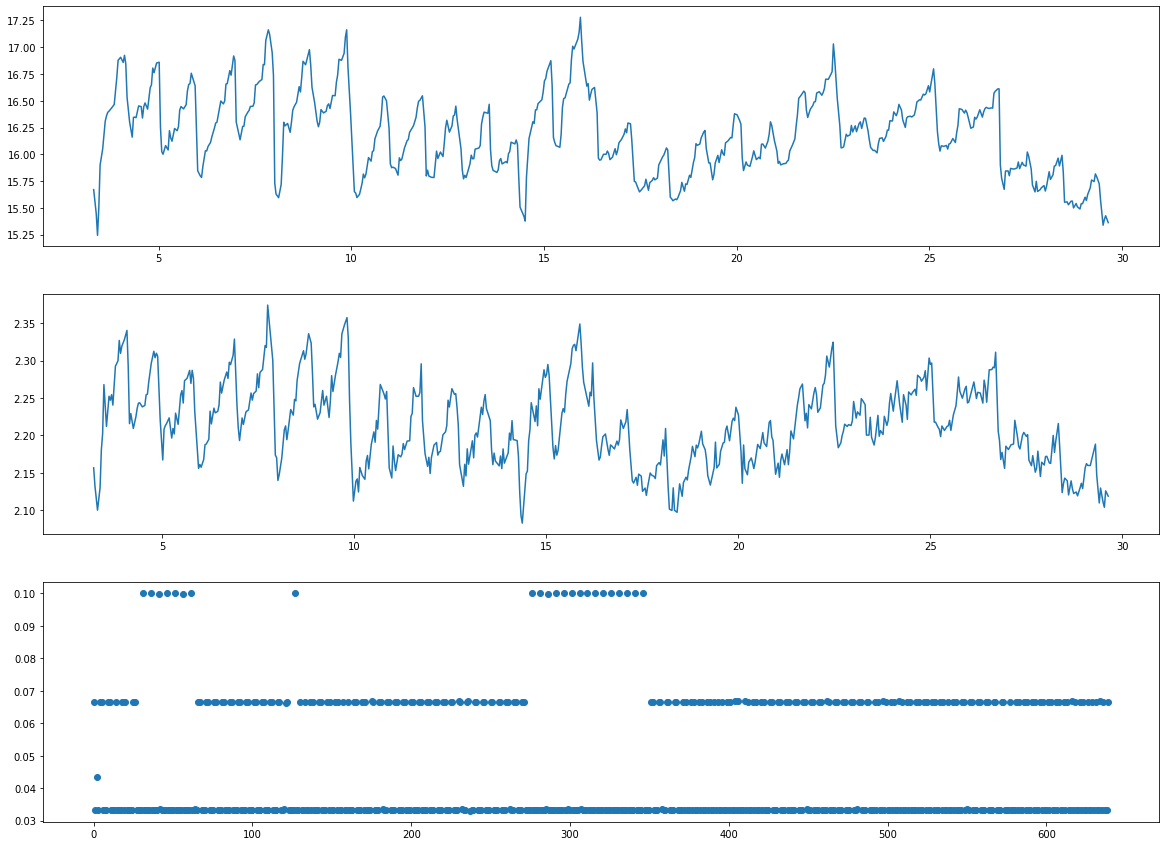

In [0]:
# Explore the signal
fig = plt.figure(figsize=(20,15))

red_plt = fig.add_subplot(311)
blue_plt = fig.add_subplot(312)
delta_t = fig.add_subplot(313)

red_plt.plot(time_points[signal_cut+red_time_diff:], red_array[signal_cut:])
blue_plt.plot(time_points[signal_cut+blue_time_diff:], blue_array[signal_cut:])
delta_t.scatter(range(time_points.size-1), np.diff(time_points))

#fig.savefig("./raw_sample.png")

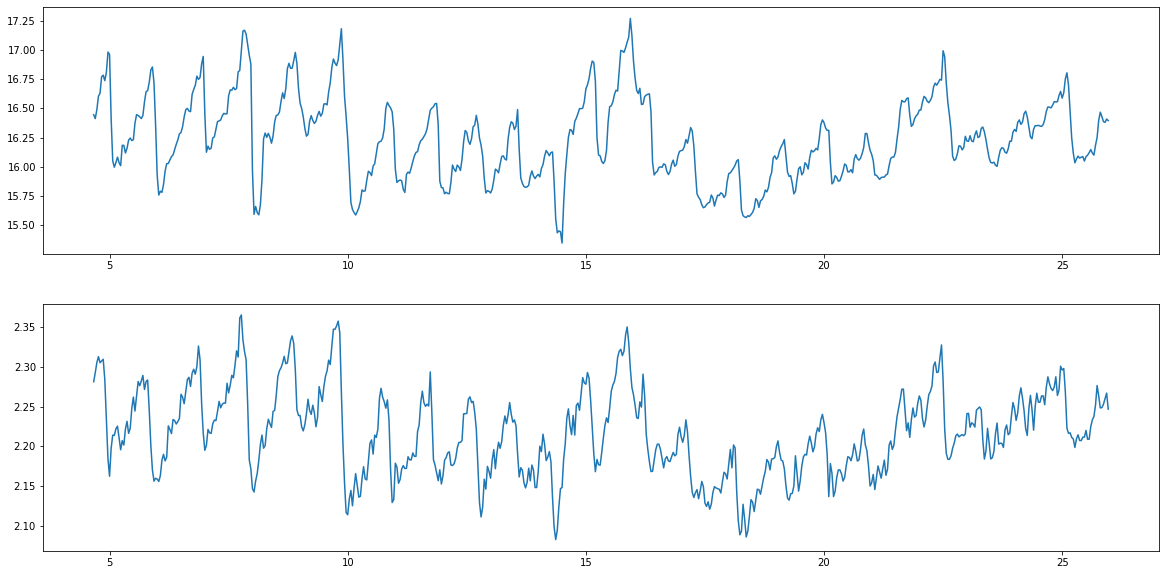

In [0]:
# Let's interpolate

spaced_time_points = np.arange(0,30,1/30)
f_red = interp.CubicSpline(time_points[signal_cut+red_time_diff:], red_array[signal_cut:])
f_blue = interp.CubicSpline(time_points[signal_cut+ blue_time_diff:], blue_array[signal_cut:])

resampled_red = f_red(spaced_time_points[int(signal_cut*2):len(spaced_time_points)-120])
resampled_blue = f_blue(spaced_time_points[int(signal_cut*2):len(spaced_time_points)-120])

cut_points= spaced_time_points[int(signal_cut*2):len(spaced_time_points)-120]

fig = plt.figure(figsize=(20,10))
red_re = fig.add_subplot(211)
blue_re = fig.add_subplot(212)

red_re.plot(cut_points, resampled_red)
blue_re.plot(cut_points, resampled_blue)


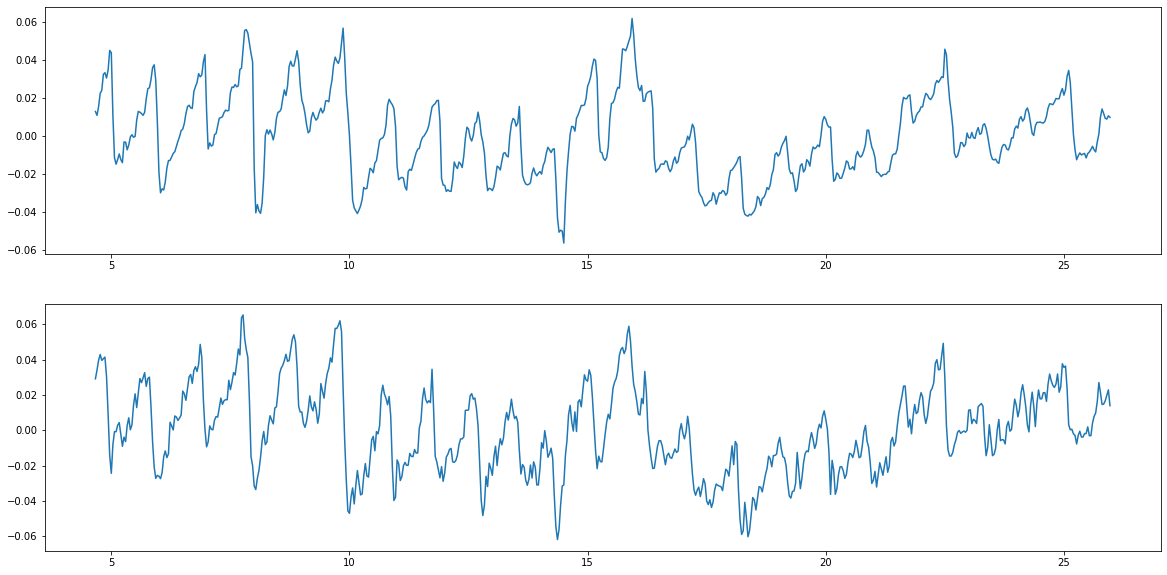

In [0]:
# Ln of the signal
red_ln = np.log(resampled_red)
blue_ln = np.log(resampled_blue)

red_ln_pulse = red_ln - red_ln.mean()
blue_ln_pulse = blue_ln -blue_ln.mean()

fig = plt.figure(figsize=(20,10))
red_re = fig.add_subplot(211)
blue_re = fig.add_subplot(212)

red_re.plot(cut_points, red_ln_pulse)
blue_re.plot(cut_points, blue_ln_pulse)


In [0]:
(resampled_red.std()/resampled_red.mean())/(resampled_blue.std()/resampled_blue.mean())

0.8978598765743738

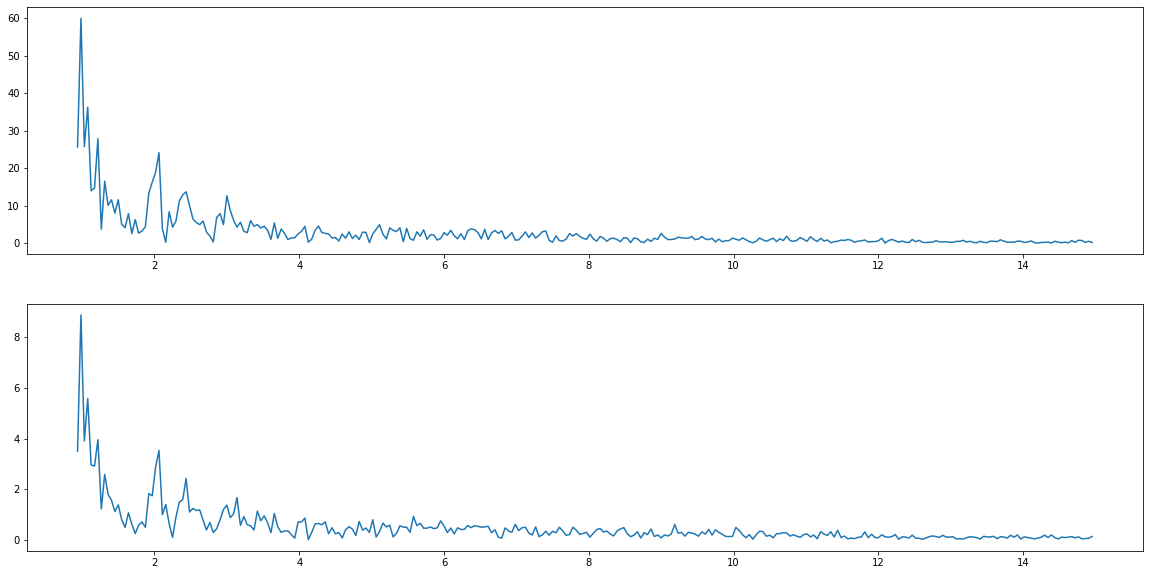

In [0]:
# fft analysis
freq = np.fft.fftfreq(cut_points.size, d=1/30)
trans_red = np.abs(np.fft.fft(resampled_red-resampled_red.mean()))[20:int(np.floor(resampled_red.size/2))]
trans_blue = np.abs(np.fft.fft(resampled_blue-resampled_blue.mean()))[20:int(np.floor(resampled_blue.size/2))]


fig = plt.figure(figsize=(20,10))
#plt.xticks(np.arange(0,10,0.5))

red_fft = fig.add_subplot(211)
blue_fft = fig.add_subplot(212)
freq = freq[20:int(np.floor(resampled_red.size/2))]

red_fft.plot(freq, trans_red)
blue_fft.plot(freq, trans_blue)

#fig.savefig("./fft_bluered.png")



In [0]:
def get_maxes_sum(sig):
     positions = []
     for i in range(4):
         next_max = np.argmax(sig[positions[i-1]+15:]) if i > 0 else np.argmax(sig)     
         pos = next_max+positions[i-1] if i>0 else next_max
         positions.append(pos)
     return sig[positions].sum()

In [0]:
(get_maxes_sum(trans_red)/np.mean(resampled_red))/(get_maxes_sum(trans_blue)/np.mean(resampled_blue))

0.8631729051977697

In [0]:
freq[12:int(np.floor(resampled_red.size/2))][23]*60

154.6875

In [0]:
# find red peaks -> pluse
data_set = pd.DataFrame({'red':resampled_red, 'blue': resampled_blue})
window = 0.75
fs=30
move_avg = data_set['red'].rolling(int(window*fs)).mean()
avg_red = data_set['red'].mean()

max_window = []
min_window = []
red_max_list = []
red_min_list = []

listpos = 0 

for datapoint in data_set.red:
    rollingmean = move_avg[listpos]
    if (datapoint > rollingmean): 
        max_window.append(datapoint)
        listpos += 1
        if len(min_window) > 0:
            min_pos = listpos - len(min_window) + (min_window.index(min(min_window)))-1
            red_min_list.append(min_pos)
            min_window = []
        
    else:  # we add points below the MA to the min window
        min_window.append(datapoint)
        listpos += 1
        if len(max_window) > 0:
            max_pos = listpos - len(max_window) + (max_window.index(max(max_window))) -1
            red_max_list.append(max_pos) 
            max_window = [] 
            
            
        

red_peaks = [data_set.red[x] for x in red_max_list]

red_mins = [data_set.red[x] for x in red_min_list] 

In [0]:
# find blue peaks

blue_max_list = []
blue_min_list = []

for i, max_ind in enumerate(red_max_list):
    
    # Determine the last index we should look at for the window
    last_ind = 0
    if i ==(len(red_max_list)-1):
        last_ind = data_set.blue.size-1
    else:
        last_ind= red_max_list[i+1]

    # Determine the first index (where the last maximum is)
    start_ind = blue_max_list[i-1] if len(blue_max_list) >0 else max_ind

    # Find the min
    blue_min_ind = np.argmin(data_set.blue[start_ind: last_ind])
    blue_min_list.append(start_ind + blue_min_ind)

    # Find the next max between the min and the end of the period
    blue_max_ind = np.argmax(data_set.blue[start_ind + blue_min_ind: last_ind])
    blue_max_list.append(start_ind + blue_min_ind + blue_max_ind)

blue_peaks = [data_set.blue[x] for x in blue_max_list] 
blue_mins = [data_set.blue[x] for x in blue_min_list] 


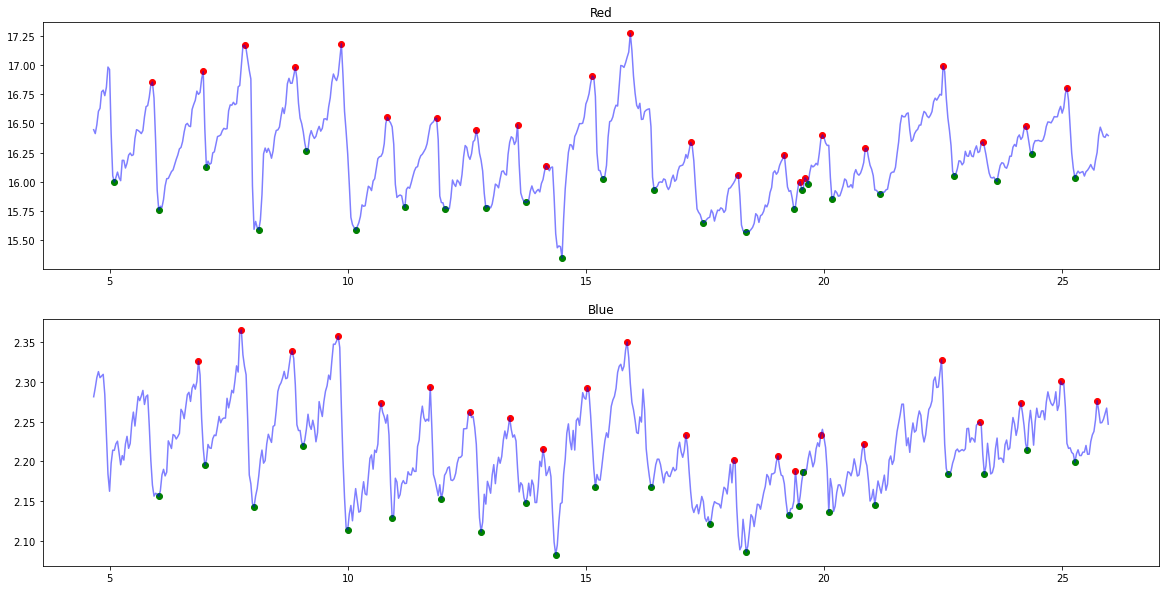

In [0]:
# Explore max and min
fig = plt.figure(figsize=(20,10))
red_peaks_plt = fig.add_subplot(211)
blue_peaks_plt = fig.add_subplot(212)

red_peaks_plt.plot(cut_points,data_set.red, alpha=0.5, color='blue') 
red_peaks_plt.scatter(cut_points[red_max_list], red_peaks, color='red')
red_peaks_plt.scatter(cut_points[red_min_list], red_mins, color='green')
red_peaks_plt.set_title("Red")

blue_peaks_plt.plot(cut_points,data_set.blue, alpha=0.5, color='blue') 
blue_peaks_plt.scatter(cut_points[blue_max_list], blue_peaks, color='red')
blue_peaks_plt.scatter(cut_points[blue_min_list], blue_mins, color='green')
blue_peaks_plt.set_title("Blue")

#plt.savefig("peaks.png")
plt.show()


In [0]:
red_ratios = np.array(red_mins[2:])/np.array(red_peaks[1:])
blue_ratios = np.array(blue_mins[:-1])/np.array(blue_peaks[:-1])
ratios = red_ratios/blue_ratios


In [0]:

def calculate_saturation(e_hb,e_hr,e_hob,e_hor):
    sats = []
    for red_max_i, red_min_i,blue_max_i,blue_min_i in zip(red_max_list[:], red_min_list[:-1], blue_max_list[:], blue_min_list[:]): 
        m_r = (red_ln_pulse[red_max_i] - red_ln_pulse[red_min_i])/(cut_points[red_max_i]- cut_points[red_min_i])
        m_b = (blue_ln_pulse[blue_max_i] - blue_ln_pulse[blue_min_i])/(cut_points[blue_max_i]- cut_points[blue_min_i])
        vp_r = red_ln_pulse[red_max_i]
        vp_b = blue_ln_pulse[blue_max_i]

        if vp_r<0 or vp_b < 0:
            continue
        sqrt_r = np.sqrt(m_r*vp_r)
        sqrt_b = np.sqrt(m_b*vp_b)

        nom = e_hr*sqrt_b - e_hb*sqrt_r
        denom = sqrt_b*(e_hr-e_hor) - sqrt_r*(e_hb-e_hob)
        
        sats.append(nom/denom)
    return np.array(sats)


In [0]:
calculate_saturation(16156.4,319.6,33209.2,3226.56)

array([-1.1969595 , -1.20546397, -1.1542706 , -1.12163498, -1.0775571 ,
       -1.19900058, -1.14844425, -1.25235865, -1.13496679, -0.97679093,
       -1.01011005, -4.8837713 , -1.03282556, -1.63222858, -1.28880579,
       -1.14498313])

In [0]:
def calculate_ratio_saturation(r, e_hb,e_hr,e_hob,e_hor):
    nom = r*e_hb -e_hr
    denom = e_hor - e_hr - r*(e_hob-e_hb)
    return nom/denom

In [0]:
blue_start = 400
blue_end =500
red_start = 600
red_end = 700

coef = pd.read_csv('./extinction_coef.csv')


bluz = np.array([x for x in range(blue_start, blue_end,2)])
redz = np.array([x for x in range(red_start,red_end,2)])

m_b = coef[(coef['lambda']>=blue_start)&(coef['lambda']<=blue_end)]['Hb'].mean()
m_bo = coef[(coef['lambda']>=blue_start)&(coef['lambda']<=blue_end)]['Hb02'].mean()

m_r = coef[(coef['lambda']>=red_start)&(coef['lambda']<=red_end)]['Hb'].mean()
m_ro = coef[(coef['lambda']>=red_start)&(coef['lambda']<=red_end)]['Hb02'].mean()

r_saturations = [calculate_ratio_saturation(r, m_b,m_r, m_bo, m_ro) for r in ratios]
saturations = np.zeros(shape=(bluz.size*redz.size))
sat= calculate_saturation(m_b,m_r,m_bo, m_ro) *100
# for i,blu in enumerate(bluz):
#     for j,redl in enumerate(redz):
#         e_hb = coef[coef['lambda']==blu]['Hb'].iloc[0]
#         e_hob = coef[coef['lambda']==blu]['Hb02'].iloc[0]
#         e_hr = coef[coef['lambda']==redl]['Hb'].iloc[0]
#         e_hor = coef[coef['lambda']==redl]['Hb02'].iloc[0]
#         sat = calculate_saturation(e_hb,e_hr,e_hob, e_hor) *100
#         saturations[i*redz.size+j] = sat.mean()



In [0]:
sat

array([ 640.32984012,  642.91136723,  627.14327145,  616.79776631,
        602.44603503,  640.95076578,  625.31339626,  656.88360611,
        621.05222861,  567.89415696,  579.59813617, 1138.96867655,
        587.41675576,  755.78656923,  667.44522845,  624.22287957])

In [0]:
ratios.mean()

1.0107528175952545